In [1]:
#!pip install networkx
!pip install node2vec
!pip install scikit-network

In [207]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import json
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
import re

In [208]:
def get_json():
    json_files = [pos_json for pos_json in os.listdir("./data") if pos_json.endswith('.json')]
    return json_files

In [209]:
def unique_hashtags():
    json_files = get_json()
    count = 0
    hashtags=[]
    for file in json_files:
        print(file)
        file = open('./data/'+file) 
        data = json.load(file)
        for tweet in data:
            curhash = re.findall("#([a-zA-Z0-9_]{1,50})", tweet['text']) 
            if curhash != []:
                #print(curhash)
                for curtag in curhash:
                    flag = 0
                    for tag in hashtags:
                        if tag == curtag:
                            flag=1
                    if flag == 0:
                        hashtags.append(curtag)
        count+=len(data)
        df = pd.DataFrame(columns=hashtags)
    return df


In [210]:
def populate(hashtags):
    json_files = get_json()
    for file in json_files:
        print(file)
        filename = file.split('.')[0]
        hashtags.loc[filename] =0
        file = open('./data/'+file) 
        data = json.load(file)
        for tweet in data:
            curhash = re.findall(r"#(\w+)", tweet['text'])
            if curhash != []:
                #print(curhash[0])
                for curhashi in curhash:    
                    for hashtag in hashtags.columns:
                        if(curhashi == hashtag):
                            #print(curhash[0]+'  '+hashtag)
                            hashtags.loc[filename,hashtag]=hashtags.loc[filename,hashtag]+1
    return hashtags


In [211]:
def mentions():
    json_files=get_json()
    #print(json_files)
    arr_filenames=[]
    for file in json_files:
        arr_filenames.append(file.split('.')[0])
    df = pd.DataFrame(columns=arr_filenames,index=arr_filenames)
    count = 0
    for file in json_files:
        print(count)
        file = open('./data/'+file) 
        data = json.load(file)
        arr_mentions=[]
        for tweet in data:
            result = re.findall("@([a-zA-Z0-9_]{1,50})", tweet['text'])
            if result!=[]:    
                #print(tweet['text'])
                #print(result)
                #print('\n')
                for mention in result:
                    arr_mentions.append(mention)
        #print(arr_mentions)
        arr = np.zeros(len(arr_filenames))
        for mention in arr_mentions:
            #if mention == arr_filenames[count]:
                #print(tweet['text'])
            for i in range (0,len(arr_filenames)):
                if arr_filenames[i].lower()==mention.lower():
                    #print(mention.lower())
                    arr[i]=arr[i]+1
        df.loc[arr_filenames[count]] = arr
        count=count+1
    #df.to_csv('mentions.csv')
    return df

In [212]:
def read_hashtag():
    hashtags = pd.read_csv('hashtag_table_final_corrected.csv',index_col=0)
    return hashtags

In [213]:
def read_mentions():
    df2 = pd.read_csv('mentions_final.csv',index_col=0)
    return df2

In [10]:
mentiondf = read_mentions()
hashtagdf = read_hashtag()

In [214]:
def getadjacency(x=0):
    if(x==1):
        df = read_mentions()
        ans_df=pd.DataFrame(columns=('Source','Target','Weight'))
        count=0
        for i in df.index:
            for j in df.columns:
                if(df.loc[i,j]!=0 and i!=j):
                    ans_df.loc[count]=[i,j,df.loc[i,j]]
                    count=count+1
    
        return ans_df
    return pd.read_csv('adjacency.csv',index_col=0)

def Plot_Directed_Graph():
    adjacency = getadjacency()
    G = nx.Graph()
    G = nx.from_pandas_edgelist(adjacency,'Source','Target','Weight')
    values = {}
    maximum = adjacency.groupby(['Source'])['Weight'].sum().max() 
    dfw = pd.DataFrame(adjacency.groupby(['Source'])['Weight'].sum())
    #print(dfw)
    for i in range(0,len(dfw)):
        if (dfw.iloc[i][0]) <=49:
            values[dfw.index[i]]=0.2
        elif (dfw.iloc[i][0]) <=172:
            values[dfw.index[i]]=0.5
        elif ((dfw.iloc[i][0])) <= 352:
            values[dfw.index[i]]=0.7
        else:
            values[dfw.index[i]] = 0.9
    values
    val_map = [values.get(node,0.5) for node in G.nodes()]

    fig, ax = plt.subplots(figsize = (40, 40))
    ColorLegend = {'Rarely Mentioned': 0.2,'Sometimes Mentioned': 0.5,'Often Mentioned': 0.7,'Highly Mentioned': 0.9}
    jet = cm = plt.get_cmap('jet')
    cNorm  = colors.Normalize(vmin=0, vmax=1)
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=jet)
    for label in ColorLegend:
        ax.plot([0],[0],color=scalarMap.to_rgba(ColorLegend[label]),label=label)
    nx.draw(G,node_size=500,cmap=jet,node_color = val_map)
    plt.legend(prop={'size':40})
    plt.show()
    return G,dfw

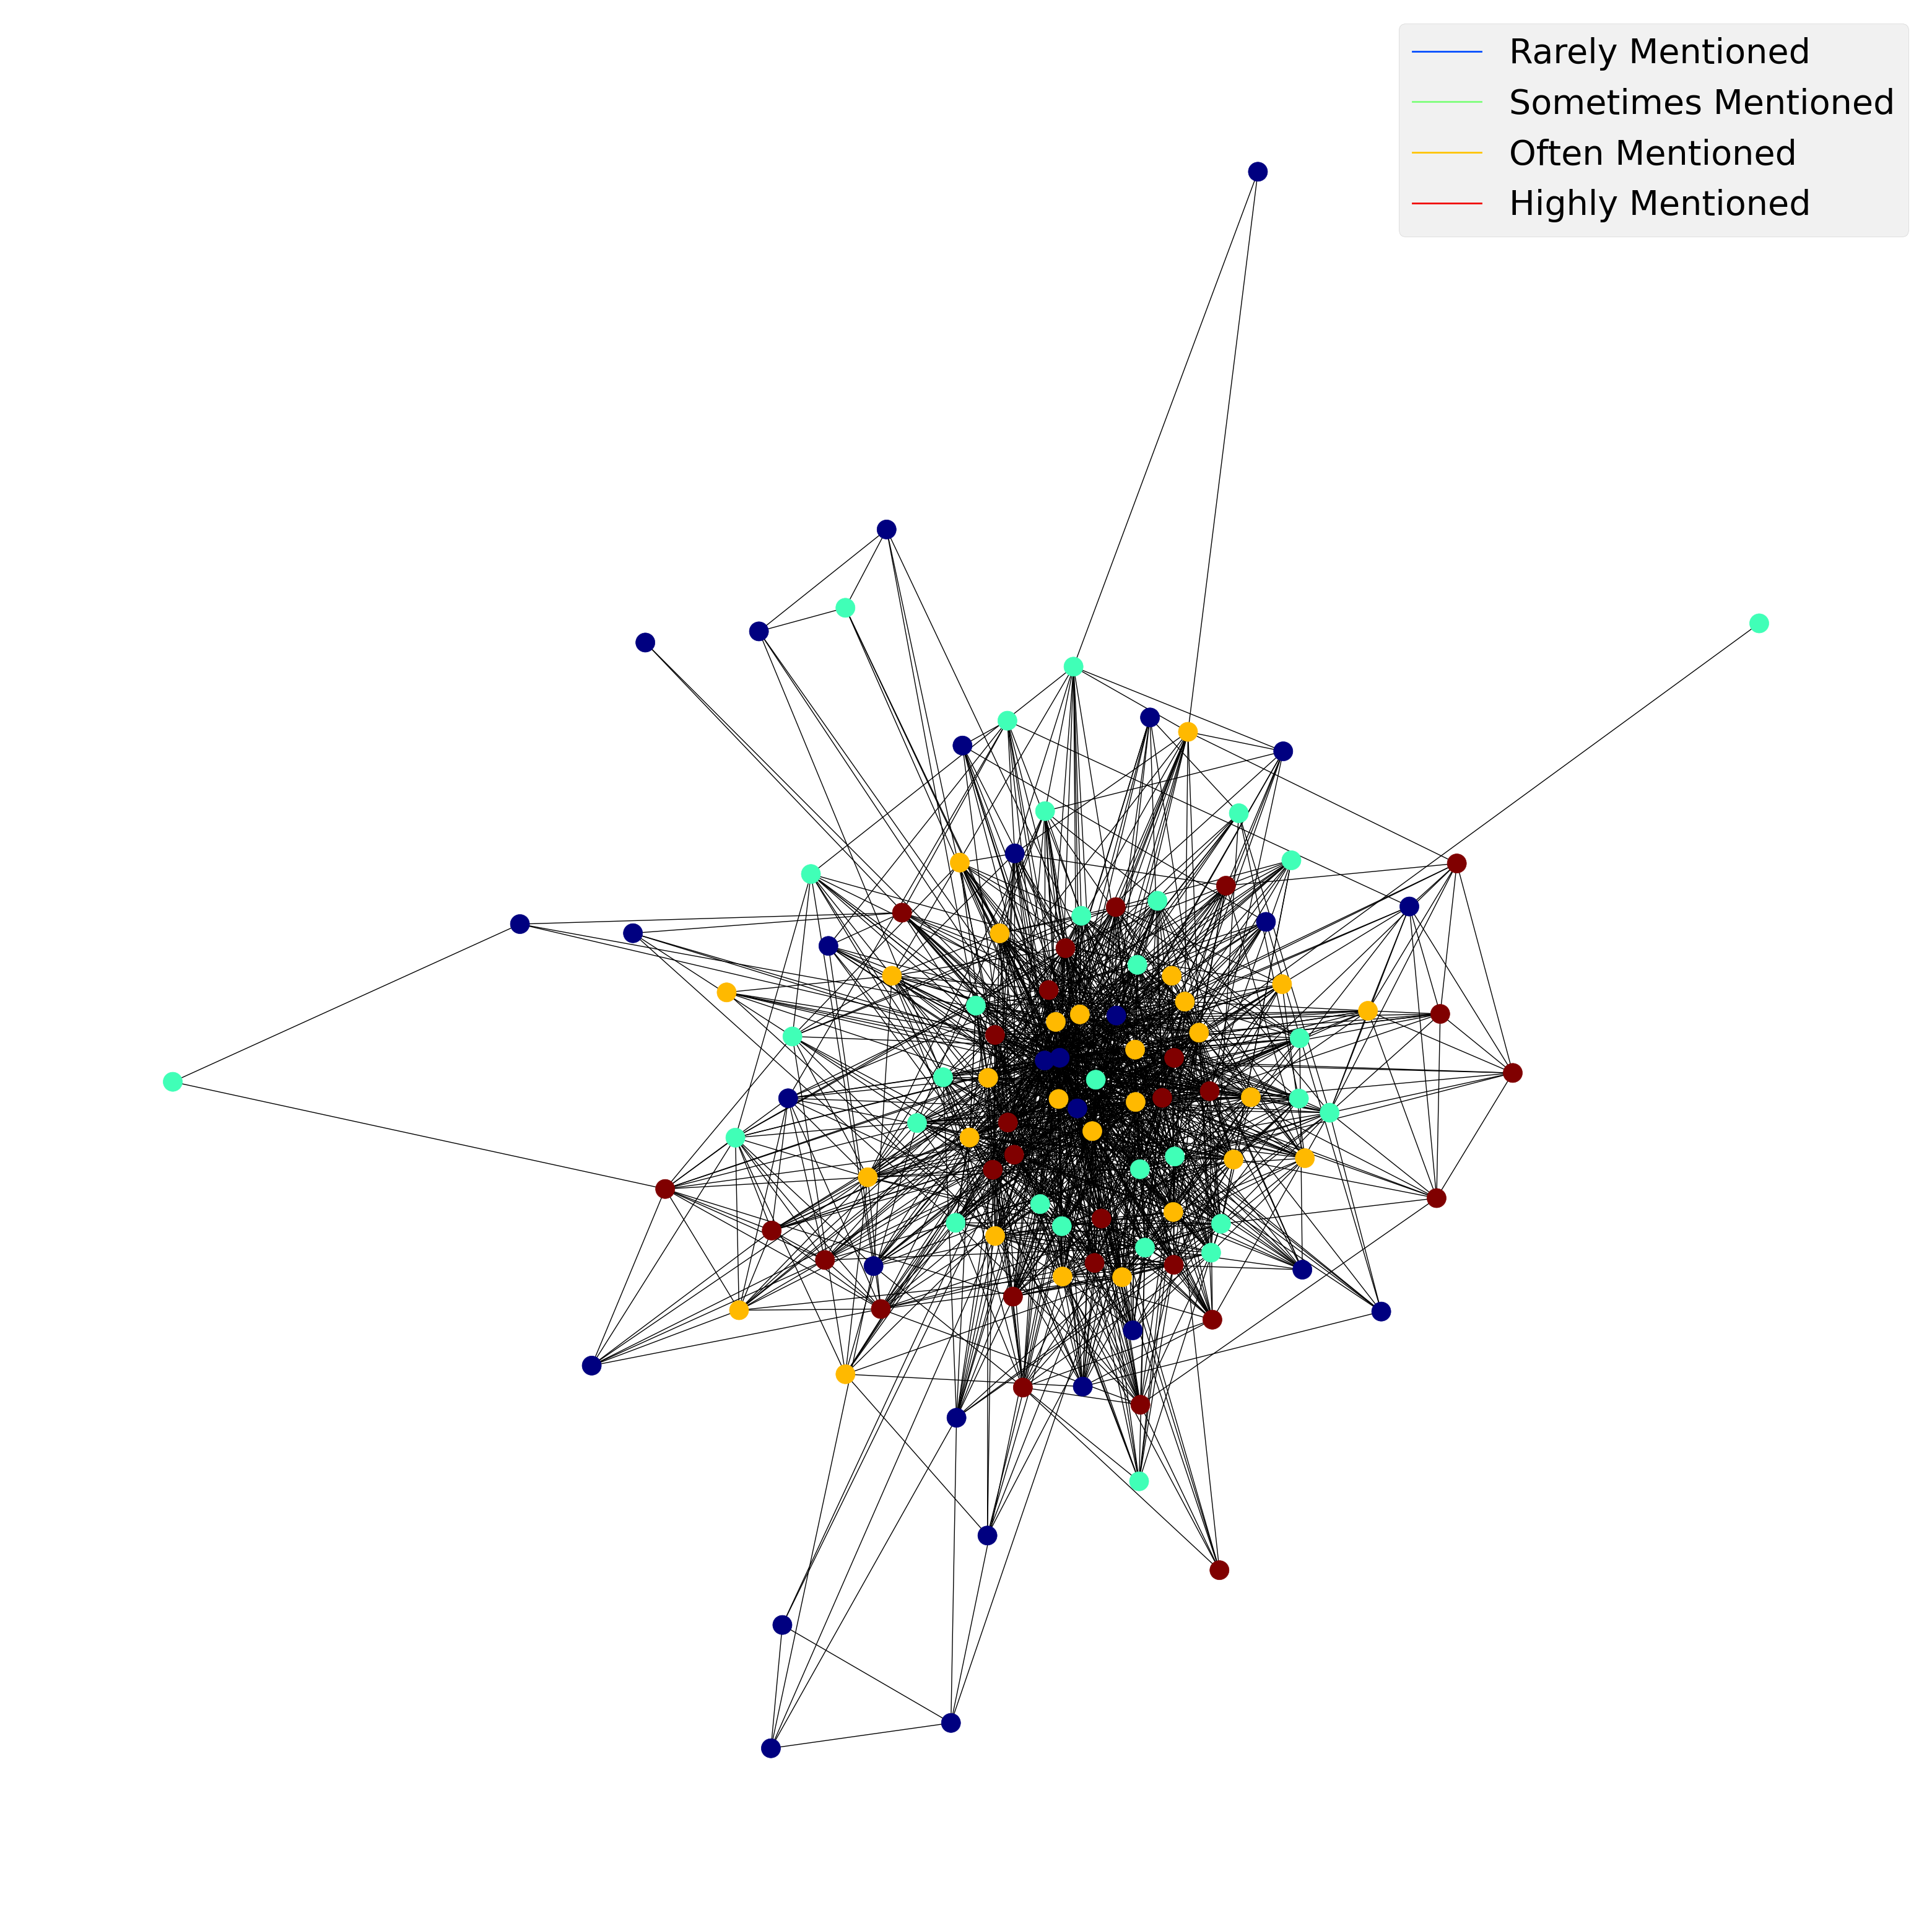

In [263]:
G,dfw = Plot_Directed_Graph()

In [261]:
def time_tweet_plot(timelist=np.zeros(24,dtype=int)):    
    json_files=get_json()
    if(timelist[0]==0):
        for file in json_files:
            filename = file.split('.')[0]
            print(filename)
            file = open('./data/'+file) 
            data = json.load(file)
            for tweet in data:
                timelist[(int(tweet['created_at'].split(':')[0][-2:])+5)%24]+=1
    print(timelist)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax2=ax.twinx()
    df = pd.DataFrame(pd.DataFrame({'Number of Tweets':timelist}))
    df2 = pd.DataFrame(columns=['Cumulative Mean'])
    df3 = pd.DataFrame(columns=['Total'])
    df2['Cumulative Mean']= df['Number of Tweets'].cumsum()/(df.index+1)
    df3['Total'] = df['Number of Tweets'].cumsum()
    df3.plot(kind='line',ax=ax2,color='#FF0000')
    ax2.legend(loc=(0.015,0.93))
    df2.plot(color='#0d98ba',kind='line',ax=ax)
    df.plot(kind='bar',ax=ax,width=0.7,color='#1F9E82')
    plt.plot(height=timelist,color='#1F9E82',ax=ax)
    ax.legend(loc=(0.015,0.855))
    plt.ticklabel_format(style='plain', axis='y') # To display the total pay in actual numbers in plain format
    plt.style.use('bmh')
    plt.xlabel('\nTime in hours\n', fontsize = 15)
    plt.tick_params(labelsize = 10)
    ax.set_xlabel('\nTime in hours\n', fontsize = 15)
    #plt.figure=(10,10)
    plt.show()
    return timelist

[ 1090   387   128   149   180   581  2070  5718 10844 18230 26079 27618
 24273 21766 21824 23427 25117 24536 21619 19718 16559 13990  8632  4032]


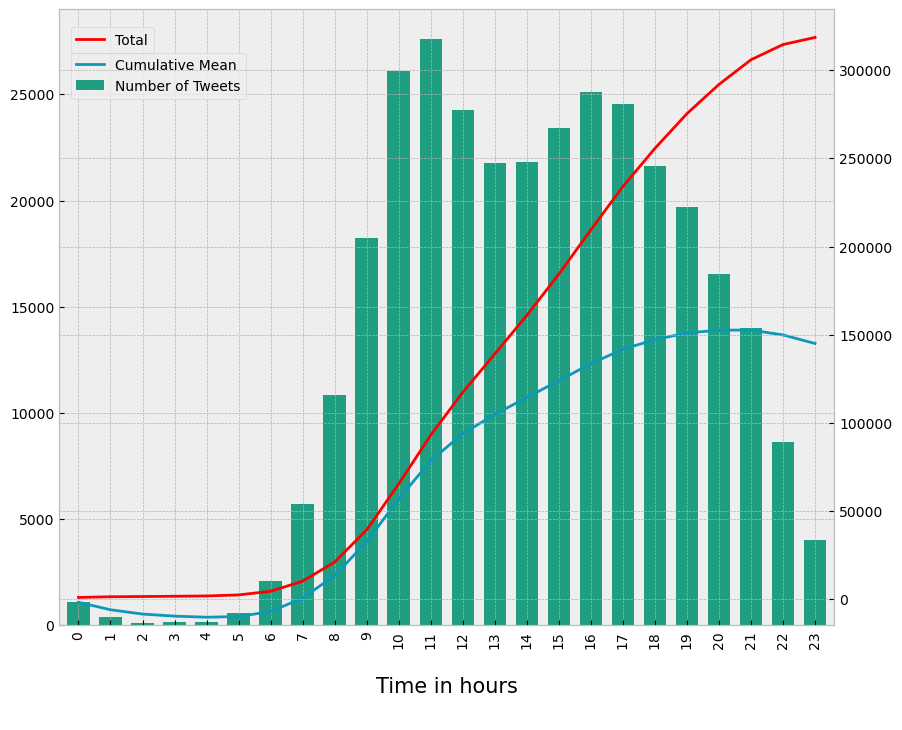

array([ 1090,   387,   128,   149,   180,   581,  2070,  5718, 10844,
       18230, 26079, 27618, 24273, 21766, 21824, 23427, 25117, 24536,
       21619, 19718, 16559, 13990,  8632,  4032])

In [262]:
#timelist = time_tweet_plot()
time_tweet_plot(timelist)

In [41]:
np.shape(mentiondf.to_numpy()[:5,:5])

(5, 5)

In [202]:
G = G.to_directed()
from node2vec import Node2Vec
node2vec = Node2Vec(G, dimensions=2, walk_length=20, num_walks=10,workers=4)
# Learn embeddings 
model = node2vec.fit(window=10, min_count=1)
#model.wv.most_similar('1')
model.wv.save_word2vec_format("embedding.emb")
from sklearn.cluster import KMeans
import numpy as np


X = np.loadtxt("embedding.emb", skiprows=1,usecols=(1,2)) # load the embedding of the nodes of the graph
#print(X)
# sort the embedding based on node index in the first column in X
X=X[X[:,0].argsort()]; 
#print(X)
Z=X[0:X.shape[0],1:X.shape[1]]; # remove the node index from X and save in Z

kmeans = KMeans(n_clusters=10, random_state=0).fit(Z) # apply kmeans on Z
labels=kmeans.labels_  # get the cluster labels of the nodes.
print(labels)

In [232]:
for key, item in (df.groupby('cluster')):
    print((df.groupby('cluster')).get_group(key))

                      115         2  cluster
RajBhavanHry     1.192383 -0.106251        0
highereduminmp   1.138398  0.206056        0
prdjharkhand     1.050838  0.421339        0
ChiefSecyUP      1.199363 -0.140492        0
Minister_Edu     0.883363  1.961829        0
PunjabGovtIndia  1.097068  0.293937        0
maha_governor    1.207935 -0.157714        0
officecmbihar    1.111207  0.300211        0
RajGovOfficial   1.451434 -0.865876        0
IPRD_Bihar       1.034146  0.640806        0
BiharHealthDept  1.149781  0.153609        0
DDC_Delhi        0.891165  1.727195        0
                   115         2  cluster
moayush       1.128604  0.116756        1
railminindia  1.080164  0.337079        1
PIB_Guwahati  1.136786  0.046380        1
MEAIndia      1.089518  0.335829        1
finminindia   1.131635  0.092209        1
MoRD_GOI      1.221056 -0.244204        1
GoI_MeitY     1.111971  0.133005        1
                      115         2  cluster
texminindia      1.094182  0.34563